In [30]:
import gzip, json
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

data = []

for review in parse("Software.json.gz"):
  if 'vote' in review:
    data.append(review)


In [32]:
from sklearn.model_selection import train_test_split

data_t, data_test = train_test_split(data, test_size=0.1, random_state=42)
data_train, data_valid = train_test_split(data_t, test_size=0.1/0.9, random_state=42)

In [33]:
data[0]

{'overall': 1.0,
 'vote': '7',
 'verified': True,
 'reviewTime': '02 17, 2014',
 'reviewerID': 'A1BJHRQDYVAY2J',
 'asin': '0077613252',
 'style': {'Format:': ' Loose Leaf'},
 'reviewerName': 'Allan R. Baker',
 'reviewText': 'IF YOU ARE TAKING THIS CLASS DON"T WASTE YOUR MONEY ON THIS SO CALLED BOOK! $140.00 FOR A "BOOK" THAT ISIN\'T EVEN BOUND LOOSE LEAFS, THAT I HAD TO PROVIDE MY OWN BINDER FOR. TURNS OUT YOU CAN BUY ACCESS TO THE BOOK AT MCGRAW HILL CONNECT CORE FOR $70.00\n\nTHIS BOOK IS A COMPLETE WASTE OF MONEY!',
 'summary': 'ARE YOU KIDING ME?',
 'unixReviewTime': 1392595200}

In [43]:
X_train, y_train = [(d['reviewerID'], d['asin']) for d in data_train], [int(d['vote'].replace(',', '')) for d in data_train]
X_valid, y_valid = [(d['reviewerID'], d['asin']) for d in data_valid], [int(d['vote'].replace(',', '')) for d in data_valid]
X_test, y_test = [(d['reviewerID'], d['asin']) for d in data_test], [int(d['vote'].replace(',', '')) for d in data_test]

In [35]:
# X_train, y_train = [(d['reviewerID'], d['asin']) for d in data_train], [d['overall'] for d in data_train]
# X_valid, y_valid = [(d['reviewerID'], d['asin']) for d in data_valid], [d['overall'] for d in data_valid]
# X_test, y_test = [(d['reviewerID'], d['asin']) for d in data_test], [d['overall'] for d in data_test]

In [36]:
userIDs,itemIDs = {},{}

for d in X_train + X_valid + X_test:
    u,i,*rest = d
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    

nUsers,nItems = len(userIDs),len(itemIDs)

In [37]:
from sklearn.model_selection import KFold
from collections import defaultdict

class bias_only:
    def __init__(self, lambu, lambi, x_train=X_train, y_train=y_train):
        self.globalAverage = sum(y_train)/len(y_train)
        self.hoursPerUser = defaultdict(dict)
        self.hoursPerGame = defaultdict(dict)
        for (u,g),h in zip(x_train, y_train):
            self.hoursPerUser[u][g] = h
            self.hoursPerGame[g][u] = h
        self.lambu = lambu
        self.lambi = lambi
        self.alpha = self.globalAverage
        self.betaU = defaultdict(float)
        self.betaI = defaultdict(float)
        # self.betaU = {}
        # self.betaI = {}
        for u in self.hoursPerUser.keys():
            # print(u)
            self.betaU[u] = 0

        for g in self.hoursPerGame.keys():
            self.betaI[g] = 0
        self.reset_params()

    def reset_params(self):
        self.alpha = self.globalAverage
        self.betaU = defaultdict(float)
        self.betaI = defaultdict(float)
        # self.betaU = {}
        # self.betaI = {}
        for u in self.hoursPerUser.keys():
            self.betaU[u] = 0

        for g in self.hoursPerGame.keys():
            self.betaI[g] = 0

    def calcMSE(self, x_valid, y_valid):
        MSE = 0
        for (u,g),R in zip(x_valid, y_valid):
            pred = self.pred(u,g)
            # print(pred,R)
            MSE += (pred - R)**2
        return MSE/len(x_valid)
    
    def pred(self, u, g):
        # print(u,g)
        return self.alpha + self.betaU[u] + self.betaI[g]

    def predict(self, pairs):
        return [self.pred(u,g) for u,g,*_ in pairs]

    def iterate(self, x_train, y_train, x_valid=None, y_valid = None, iters=None, patience=20):
        MSE = 1e12
        new_MSE = 1e6
        i = 0    
        iters_not_improving = 0
        best_mse = float('inf')
        while (iters_not_improving < patience):
            if iters:
                if i >= round(iters):
                    print('breaking early because of iters')
                    break
            i += 1
            if not iters:
                MSE = new_MSE
            new_alpha = 0
            for (u,g),R in zip(x_train, y_train):
                new_alpha += (R - (self.betaU[u] + self.betaI[g])) / len(x_train)
            self.alpha = new_alpha

            for g in self.hoursPerGame.keys():
                self.betaI[g] = 0
                for u,R in self.hoursPerGame[g].items():
                    self.betaI[g] += (R - (self.alpha + self.betaU[u])) / (len(self.hoursPerGame[g]) + self.lambi)
            for u in self.hoursPerUser.keys():
                self.betaU[u] = 0
                for g,R in self.hoursPerUser[u].items():
                    self.betaU[u] += (R - (self.alpha + self.betaI[g])) / (len(self.hoursPerUser[u]) + self.lambu)
            if not iters:
                new_MSE = self.calcMSE(x_valid, y_valid)
            if not new_MSE < best_mse:
                # print(new_MSE, best_mse)
                iters_not_improving += 1
            else:
                iters_not_improving = 0
                best_mse = new_MSE
                self.best_alpha = self.alpha
                self.best_betaU = self.betaU.copy()
                self.best_betaI = self.betaI.copy()
            
            # print(new_MSE, best_mse)
        self.alpha = self.best_alpha
        self.betaU = self.best_betaU.copy()
        self.betaI = self.best_betaI.copy()
        return self.calcMSE(x_train, y_train), i 

    def train_cv(self, dataset, n_splits=10):
        data = [(d[0],d[1],d[2]['hours_transformed']) for d in dataset]
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        avg_mse = 0
        avg_iters = 0

        for train_index, test_index in kf.split(data):
            hoursTrain = [data[i] for i in train_index]
            hoursTest = [data[i] for i in test_index]

            self.reset_params()
            mse,iters  = self.iterate(hoursTrain, hoursTest)
            # print(mse)

            avg_mse += mse/n_splits
            avg_iters += iters/n_splits
        return avg_mse, iters


In [39]:
from tqdm import tqdm
import numpy as np

best_err = 1e12
best_lamb = None
best_model = None

lambs = []
errors = []
iters = []


for lambi in tqdm(np.logspace(-10,0,10)):
    for lambu in np.logspace(-10,0,10):
        model = bias_only(lambu,lambi, X_train, y_train)
        valid_err, i = model.iterate(X_train, y_train, X_valid, y_valid, patience=20)
        # valid_err, i = model.train_cv(dataset)
        # model.iterate([(d[0],d[1],d[2]['hours_transformed']) for d in dataset],iters=i)
        # valid_err, i = model.iterate([(d[0],d[1],d[2]['hours_transformed']) for d in dataset],iters=i)
        # print(lamb, valid_err)
        lambs.append([lambu, lambi])
        errors.append(valid_err)
        iters.append(i)
        if valid_err < best_err:
            best_err = valid_err
            best_lamb = lamb
            best_model = model
        # print(best_model)

100%|██████████| 10/10 [09:41<00:00, 58.19s/it]


In [44]:
print(best_err)

484.66490430698286


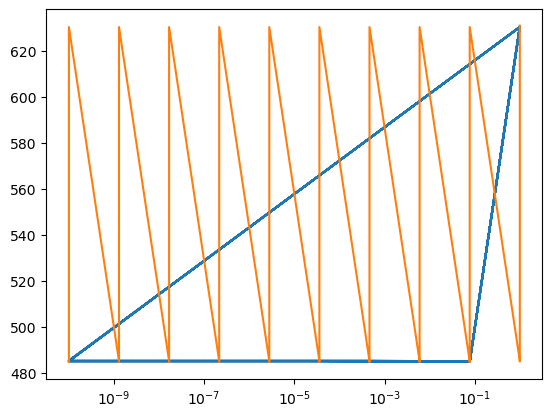

In [41]:
plt.plot(lambs, errors)
plt.xscale('log')

In [42]:
betaU = [best_model.betaU[u] if u in best_model.betaU else 0 for u in userIDs.keys()]
betaI = [best_model.betaI[i] if i in best_model.betaI else 0 for i in itemIDs.keys()]
alpha = best_model.alpha

In [214]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import math
from time import sleep
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset


# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LatentFactorModel(nn.Module):
    def __init__(self, userIDs=userIDs, itemIDs=itemIDs, K=1, lambdaG=0.01, lambdaU=0.01, learning_rate=0.1, 
                 alpha_init=0.0, betaU_init=None, betaI_init=None, patience=5, print_output=False, seed=42):
        super(LatentFactorModel, self).__init__()

        # Set seed for PyTorch random number generator
        torch.manual_seed(seed)

        # Set seed for NumPy random number generator (if using NumPy operations)
        np.random.seed(seed)

        # Set seed for CUDA (GPU) operations (if using GPU)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        # Your PyTorch model and training code here

        # Initialize model parameters and hyperparameters
        self.num_users = len(userIDs)
        self.num_items = len(itemIDs)

        self.gammaU = nn.Embedding(self.num_users, K).half()
        self.gammaI = nn.Embedding(self.num_items, K).half()
        init.normal_(self.gammaU.weight.data, mean=0, std=0.001)
        init.normal_(self.gammaI.weight.data, mean=0, std=0.001)
        # init.uniform_(self.gammaU.weight.data, a=-5, b=5)
        # init.uniform_(self.gammaI.weight.data, a=-5, b=5)

        
        # init.constant_(self.gammaU.weight.data, 0)
        # init.constant_(self.gammaI.weight.data, 0)

        self.alpha = nn.Parameter(torch.Tensor([alpha_init]))
        self.betaU = nn.Embedding(self.num_users, 1)
        self.betaI = nn.Embedding(self.num_items, 1)
        if betaU_init is not None:
            self.betaU.weight.data = torch.Tensor(betaU_init).view(-1, 1)
        if betaI_init is not None:
            self.betaI.weight.data = torch.Tensor(betaI_init).view(-1, 1)

        self.lambdaG = lambdaG
        self.lambdaU = lambdaU
        self.learning_rate = learning_rate
        self.patience = patience
        self.best_val_rmse = float('inf')
        self.num_epochs_no_improve = 0
        self.print_output = print_output
        self.best_state = self.state_dict()
        self.seed = seed

        self.to(device)  # Move the model to GPU

    def forward(self, user_ids, item_ids):
        user_embeds = self.gammaU(user_ids.to(device))
        item_embeds = self.gammaI(item_ids.to(device))
        dot_product = torch.sum(user_embeds * item_embeds, dim=1)

        alpha_term = self.alpha.expand_as(dot_product)
        beta_user_term = self.betaU(user_ids).squeeze().to(device)
        beta_item_term = self.betaI(item_ids).squeeze().to(device)

        prediction = dot_product + alpha_term + beta_user_term + beta_item_term
        return prediction

    def compute_loss(self, predictions, ratings):
        criterion = nn.MSELoss()
        loss = criterion(predictions, ratings)

        reg_emb_term = 0.5 * self.lambdaG * (torch.norm(self.gammaU.weight) +
                                            torch.norm(self.gammaI.weight))

        reg_beta_term = 0.5 * self.lambdaU * (torch.norm(self.betaU.weight) +
                                              torch.norm(self.betaI.weight))

        loss += reg_emb_term + reg_beta_term
        return loss

    def compute_rmse(self, predictions, ratings):
        rmse = torch.sqrt(nn.MSELoss()(predictions, ratings))
        return rmse
    
    def train(self, x, y, val_x=None, val_y=None, num_epochs=10, batch_size=4096):

        self.train_model(self.translate_x(x), y, self.translate_x(val_x), val_y, num_epochs=num_epochs, batch_size=batch_size)


    def train_model(self, x, y, val_x=None, val_y=None, num_epochs=10, batch_size=4096):
        # Convert entire dataset to tensors and move to GPU
        user_ids = torch.LongTensor(x[0]).to(device)
        item_ids = torch.LongTensor(x[1]).to(device)
        ratings = torch.FloatTensor(y).to(device)

        dataset = TensorDataset(user_ids, item_ids, ratings)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        if val_x is not None and val_y is not None:
            val_user_ids = torch.LongTensor(val_x[0]).to(device)
            val_item_ids = torch.LongTensor(val_x[1]).to(device)
            val_ratings = torch.FloatTensor(val_y).to(device)
        
        optimizer = optim.Adam([self.alpha], lr=self.learning_rate)
        # Define your loss function here

        for epoch in tqdm(range(num_epochs)):
            for batch_user_ids, batch_item_ids, batch_ratings in dataloader:
                optimizer.zero_grad()

                batch_user_ids = batch_user_ids.to(device)
                batch_item_ids = batch_item_ids.to(device)
                batch_ratings = batch_ratings.to(device)

                predictions = self(batch_user_ids, batch_item_ids)
                loss = self.compute_loss(predictions, batch_ratings)

                loss.backward()
                optimizer.step()
                torch.cuda.empty_cache() 

            # Evaluate on the validation set
            val_rmse = None
            if val_x is not None and val_y is not None:
                val_rmse = self.evaluate((val_user_ids, val_item_ids), val_ratings)

            if val_rmse is not None and val_rmse < self.best_val_rmse:
                self.best_val_rmse = val_rmse
                self.best_state = self.state_dict()
                self.num_epochs_no_improve = 0
            else:
                self.num_epochs_no_improve += 1

            if self.num_epochs_no_improve >= self.patience:
                if self.print_output:
                    print(f'Early stopping at epoch {epoch + 1} as validation RMSE has not improved.')
                break

            if self.print_output:
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, RMSE: {val_rmse.item()}')
                
        # self.load_state_dict(self.state_dict()
    def translate_x(self,x):
        if not x: return None
        x = [[userIDs[d[0]],[itemIDs[d[1]]]] for d in x]
        
        if isinstance(x, tuple):
            user_ids, item_ids = x
        else:
            user_ids, item_ids = zip(*x)

        user_ids, item_ids = np.array(user_ids), np.array(item_ids)

        return (user_ids, item_ids)
        

    def cross_validate(self, x, y, num_folds=5, num_epochs=10, num_inner_epochs=1):
        # random.shuffle(x)
        # random.shuffle(y)
        x = [[userIDs[d[0]],[itemIDs[d[1]]]] for d in x]
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        fold_rmse = []

        if isinstance(x, tuple):
            user_ids, item_ids = x
        else:
            user_ids, item_ids = zip(*x)

        user_ids, item_ids = np.array(user_ids), np.array(item_ids)

        num_outer_epochs = math.ceil(num_epochs/num_inner_epochs)
        
        # previous_rmse = float('inf')
        average_rmse = 0
        
        user_ids_train, user_ids_test = user_ids[:len(user_ids)*9//10], user_ids[len(user_ids)*9//10:] 
        item_ids_train, item_ids_test = item_ids[:len(item_ids)*9//10], item_ids[len(item_ids)*9//10:]
        
        test_x = (user_ids_test, item_ids_test)
        test_y = y[len(user_ids)*9//10:]
        
        # print(test_x,test_y)
        previous_rmse = self.evaluate(test_x, test_y)
        # print(previous_rmse)

        for outer_epoch in range(num_outer_epochs):
            if self.print_output:
                print(f'outer_epoch {outer_epoch + 1}/{num_outer_epochs}')
            for fold, (train_idx, val_idx) in enumerate(kf.split(user_ids_train)):
                if self.print_output:
                    print(f'Fold {fold + 1}/{num_folds}')
    
                train_x = (user_ids_train[train_idx], item_ids_train[train_idx])
                train_y = [y[i] for i in train_idx]
                val_x = (user_ids_train[val_idx], item_ids_train[val_idx])
                val_y = [y[i] for i in val_idx]
    
                self.train_model(train_x, train_y, val_x, val_y, num_epochs=num_inner_epochs)
                # self.num_epochs_no_improve = 0
    
                # Evaluate on the validation set
                # average_rmse += self.evaluate(val_x, val_y)/num_folds
            average_rmse = self.evaluate(test_x, test_y)
            # print(average_rmse)
            if (not average_rmse < previous_rmse) or (outer_epoch+1 == num_outer_epochs): break
            if self.print_output:
                print(average_rmse)
            previous_rmse = average_rmse
            # average_rmse = 0
        if self.print_output:
            print(f'Average Validation RMSE: {average_rmse.item()}')
        return average_rmse
        
    # def evaluate(self, x, y):
    #     with torch.no_grad():
    #         if torch.is_tensor(x[0]) and torch.is_tensor(x[1]):
    #             user_ids = x[0].to(device)
    #             item_ids = x[1].to(device)
    #         else:
    #             user_ids = torch.LongTensor(x[0]).to(device)
    #             item_ids = torch.LongTensor(x[1]).to(device)

    #         if torch.is_tensor(y):
    #             batch_ratings = y.to(device)
    #         else:
    #             batch_ratings = torch.FloatTensor(y).to(device)

    #         predictions = self.forward(user_ids, item_ids)
    #         rmse = self.compute_rmse(predictions, batch_ratings)

    #         if self.print_output:
    #             print(f'Validation RMSE: {rmse.item()}')
    #         return rmse
    def evaluate(self, x, y, batch_size=1024):
        with torch.no_grad():
            user_ids = torch.tensor(x[0], device=device, dtype=torch.long)
            item_ids = torch.tensor(x[1], device=device, dtype=torch.long)
            ratings = torch.tensor(y, device=device, dtype=torch.float)


            dataset = TensorDataset(user_ids, item_ids, ratings)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            rmse_list = []

            for batch_user_ids, batch_item_ids, batch_ground_truth in dataloader:
                batch_user_ids = batch_user_ids.to(device)
                batch_item_ids = batch_item_ids.to(device)
                batch_ground_truth = batch_ground_truth.to(device)

                batch_predictions = self.forward(batch_user_ids, batch_item_ids)
                rmse = torch.sqrt(torch.mean((batch_predictions - batch_ground_truth)**2))
                rmse_list.append(rmse.item())

            overall_rmse = torch.sqrt(torch.mean(torch.tensor(rmse_list)**2))
            # print(overall_rmse.item())

            return overall_rmse.item()





Using device: cuda


In [215]:
torch.cuda.empty_cache() 

In [217]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

cvs = []
lambdas = []
best_cv = 6
best_lambdas = [0,0]
best_lfmodel = None
best_config = {}

params_dict = {
    'seed' : [42],
    'K' : [1,3],
    'learning_rate' : np.logspace(-4,3,5),#np.logspace(-3,-1,20),
    'alpha_init' : [alpha],
    'betaU_init' : [betaU],
    'betaI_init' : [betaI],
    # 'lambdaB' : [0.01],#np.logspace(-3,0.5,5),
    'lambdaU' : np.logspace(-5,2,5),#np.logspace(-3,0.5,5),
    # 'lambdaG' : np.linspace(0.014384-0.01,0.014384+0.01,5),
    'lambdaG' : np.logspace(-5,2,5),
    # 'patience' : np.linspace(10,100,5),#[20,50,100],
    'patience' : [10]
    # 'print_output' : [True]
}

results = []

for config in tqdm(ParameterGrid(params_dict)):
    # print('training',(b,g))
    lfmodel = LatentFactorModel(**config).to(device)
    # lfmodel.train(X_train, y_train, X_valid, y_valid, num_epochs=100, batch_size=30000)
    lfmodel.train(X_train, y_train, num_epochs=100, batch_size=20000)
    # cv = lfmodel.cross_validate(X_train, y_train, num_epochs=300, num_inner_epochs=60, num_folds=5).item()
    cv = lfmodel.evaluate(lfmodel.translate_x(X_valid),y_valid)
    # cv = cross_validate_model(lfmodel, x_train + x_valid, y_train + y_valid, num_epochs=200)
    # print(torch.sum(lfmodel.gammaI.weight.data))
    print(cv)
    results.append(config.copy())
    results[-1]['score'] = cv
    if (cv < best_cv):
        # best_lambdas = [b,g]
        best_lfmodel = LatentFactorModel(**config)
        best_lfmodel.load_state_dict(lfmodel.state_dict())
        best_config = {}
        best_cv = cv
    cvs.append(cv)
    # lambdas.append([b,g])
    del lfmodel



  0%|          | 0/250 [00:00<?, ?it/s]/usr/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 20000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2281])) that is different to the input size (torch.Size([2281, 2281])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/250 [05:26<22:33:12, 326.08s/it]

32.661521911621094


  1%|          | 2/250 [08:28<16:38:59, 241.69s/it]

32.65930938720703


  1%|          | 2/250 [08:33<17:41:22, 256.78s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/usr/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    await eval(code_obj, self.user_global_ns, self.user_ns)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_23230/4082288647.py", line 33, in <module>
    lfmodel.train(X_train, y_train, num_epochs=100, batch_size=20000)
  File "/tmp/ipykernel_23230/3248741578.py", line 101, in train
    self.train_model(self.translate_x(x), y, self.translate_x(val_x), val_y, num_epochs=num_epochs, batch_size=batch_size)
  File "/tmp/ipykernel_23230/3248741578.py", line 122, in train_model
    for batch_user_ids, batch_item_ids, batch_ratings in dataloader:
  File "/usr/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 673, in _next_data
    index = self._next_index()  # 

In [ ]:
len(X_train)

102281

In [ ]:
nUsers

109017